# a self-driving car in pytorch

## import libraries

In [1]:
# . . import libraries
import os
from pathlib import Path
# . . pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
# . . pandas 
import pandas as pd
# . . numpy
import numpy as np
# . . scikit-learn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# . . matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as npimg
# . .  set this to be able to see the figure axis labels in a dark theme
from matplotlib import style
#style.use('dark_background')
# . . to see the available options
# print(plt.style.available)

# . . import libraries by tugrulkonuk
import utils
from dataset import Dataset
from model import *
from trainer import Trainer
from callbacks import ReturnBestModel, EarlyStopping


# set device and precision

In [2]:
# . . set the device
if torch.cuda.is_available():  
    device = torch.device("cuda")  
else:  
    device = torch.device("cpu")      

#device = torch.device("cpu")      
# . . set the default tensor to cuda: DO NOT USE THIS
#torch.set_default_tensor_type('torch.cuda.FloatTensor')
# . . set the default precision
dtype = torch.float32

# . . use cudnn backend for performance
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

## import the data


In [3]:
# . . define the data directory and file name
datadir = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) +'/data/'
datafile= 'driving_log.csv'
# . . three camera images and the driving parameters
header = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
data = pd.read_csv(os.path.join(datadir,datafile), names=header)

# . . remove the header from the data
data = data.iloc[1:]

# . . display first a few rows
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,brake,speed
1,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0,0,0,22.14829
2,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0,0,0,21.87963
3,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0,0,0,1.453011
4,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0,0,0,1.438419
5,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0,0,0,1.418236


## data processing

### strip data paths from file names

In [4]:
# . . strip the path names from the camera images since they all have the same path
data['center'] = data['center'].apply(utils.strip_path)
data['left'] = data['left'].apply(utils.strip_path)
data['right'] = data['right'].apply(utils.strip_path)
data.head()

,center,left,right,steering,throttle,brake,speed
1,center_2016_12_01_13_30_48_287.jpg,left_2016_12_01_13_30_48_287.jpg,right_2016_12_01_13_30_48_287.jpg,0,0,0,22.14829
2,center_2016_12_01_13_30_48_404.jpg,left_2016_12_01_13_30_48_404.jpg,right_2016_12_01_13_30_48_404.jpg,0,0,0,21.87963
3,center_2016_12_01_13_31_12_937.jpg,left_2016_12_01_13_31_12_937.jpg,right_2016_12_01_13_31_12_937.jpg,0,0,0,1.453011
4,center_2016_12_01_13_31_13_037.jpg,left_2016_12_01_13_31_13_037.jpg,right_2016_12_01_13_31_13_037.jpg,0,0,0,1.438419
5,center_2016_12_01_13_31_13_177.jpg,left_2016_12_01_13_31_13_177.jpg,right_2016_12_01_13_31_13_177.jpg,0,0,0,1.418236


In [5]:
# . . from pandas dataframe to numpy array
img_paths = data[['center','left','right']].to_numpy()
steerings = data[['steering']].to_numpy().astype(np.float32)
#print(img_paths.shape)
# . . augment the data
#img_paths = np.repeat(img_paths, 2, axis=0)
#print(img_paths.shape)
#steerings = np.log10(1.0 + steerings)

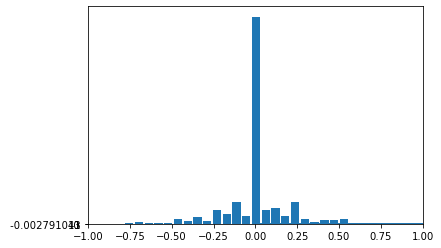

In [6]:
angle = steerings
# . . plot the steering wheel angle
num_bins = 50
samples_per_bin = 10
hist, bin_edges = np.histogram(steerings, num_bins)
# . . center bins around zero
bins = bin_edges[:-1] + bin_edges[1:] * 0.5
# . . plot the steering histogram
plt.bar(bins, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering']), samples_per_bin))
plt.xlim(-1.0,1.0)
plt.show()

(-0.5, 319.5, 159.5, -0.5)

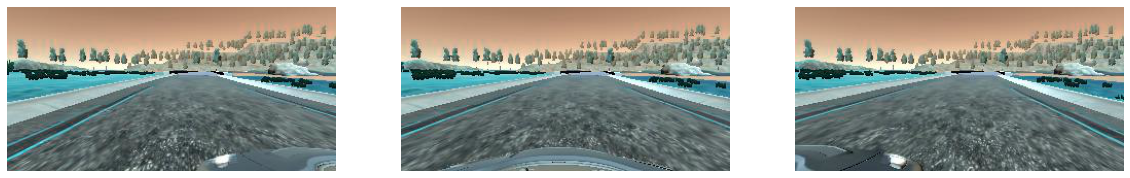

In [7]:
import cv2
frm = 50
cpath = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) +'/data/IMG/' + data['center'].iloc[frm].split('/')[-1]
lpath = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) +'/data/IMG/' + data['left'].iloc[frm].split('/')[-1]
rpath = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) +'/data/IMG/' + data['right'].iloc[frm].split('/')[-1]
center = cv2.imread(cpath)
left = cv2.imread(lpath)
right = cv2.imread(rpath)
plt.subplots(figsize=(20, 10))
plt.subplot(131),plt.imshow(left); plt.axis("off")
plt.subplot(132),plt.imshow(center); plt.axis("off")
plt.subplot(133),plt.imshow(right); plt.axis("off")


In [8]:
h_w = (64, 64)
conv1 = utils.conv_output_shape(h_w, kernel_size=5, stride=2)
conv2 = utils.conv_output_shape(conv1, kernel_size=5, stride=2)
conv3 = utils.conv_output_shape(conv2, kernel_size=5, stride=2)
conv4 = utils.conv_output_shape(conv3, kernel_size=3)
conv5 = utils.conv_output_shape(conv4, kernel_size=3)
print(conv1)
print(conv2)
print(conv3)
print(conv4)
print(conv5)

(30, 30)
(13, 13)
(5, 5)
(3, 3)
(1, 1)


(70, 320, 3)


(-0.5, 319.5, 69.5, -0.5)

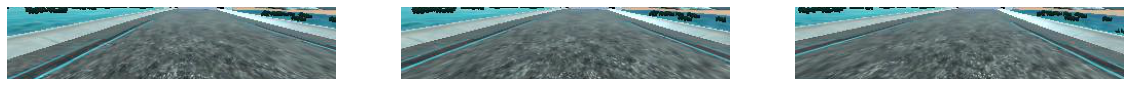

In [9]:
ccenter = center[65:-25, :, :]
cleft = left[65:-25, :, :]
cright = right[65:-25, :, :]
print(ccenter.shape)
plt.subplots(figsize=(20, 10))
plt.subplot(131),plt.imshow(cleft); plt.axis("off")
plt.subplot(132),plt.imshow(ccenter); plt.axis("off")
plt.subplot(133),plt.imshow(cright); plt.axis("off")

### prepare the data and labels

### split the data into training and validation sets

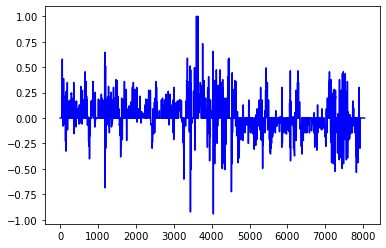

In [10]:
plt.plot(steerings,'b')

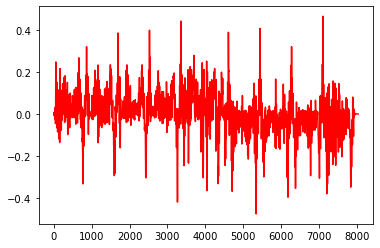

In [11]:
# . . smooth the steering angle data using the Savitzky-Golay filter
import scipy
from scipy import signal

#steerings = signal.savgol_filter(steerings.reshape(1,-1), 55, 11).reshape(-1,1)
plt.plot(signal.savgol_filter(steerings.reshape(1,-1), 55, 11).reshape(-1,1),'r')

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(img_paths, steerings, test_size=0.2)

In [13]:
# . . define the data transformations
transformations = transforms.Compose([transforms.Lambda(lambda x: (x / 255.0) - 0.5)])

# . . torch dataset
train_data = Dataset(X_train, y_train, transformations)
valid_data = Dataset(X_valid, y_valid, transformations)

# . . train and validation data loaders
trainloader = DataLoader(dataset=train_data, batch_size=256, num_workers=0, pin_memory=True)
validloader = DataLoader(dataset=valid_data, batch_size=256, num_workers=0, pin_memory=True)

In [14]:
# . . define the model
#model = NvidiaNetwork()
model = NetworkLight()
#model = NetworkTK()

In [15]:
# . . create the trainer
trainer = Trainer(model, device)

# . . compile the trainer
# . . define the loss
criterion = nn.MSELoss()
# . . define the optimizer
optimparams = {'lr':0.001
              }
# . . define the callbacks
#cb=[ReturnBestModel(), EarlyStopping(min_delta=0.00001, patience=50)]
cb=[ReturnBestModel()]
trainer.compile(optimizer='adam', callbacks=cb, **optimparams)


Selected optimization level O0:  Pure FP32 training.

Defaults for this optimization level are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O0
cast_model_type        : torch.float32
patch_torch_functions  : False
keep_batchnorm_fp32    : None
master_weights         : False
loss_scale             : 1.0


In [16]:
# . . train the network
train_loss, valid_loss = trainer.fit(trainloader, validloader, num_epochs=20)

Training started:  January 21, 2021 - 07:05PM
Epoch:     0	Train Loss: 0.148262	Valid Loss: 0.118666
Epoch:     1	Train Loss: 0.106336	Valid Loss: 0.103886
Epoch:     2	Train Loss: 0.101506	Valid Loss: 0.101955
Epoch:     3	Train Loss: 0.094038	Valid Loss: 0.092614
Epoch:     4	Train Loss: 0.093139	Valid Loss: 0.092108
Epoch:     5	Train Loss: 0.092821	Valid Loss: 0.103484
Epoch:     6	Train Loss: 0.093137	Valid Loss: 0.085213
Epoch:     7	Train Loss: 0.087197	Valid Loss: 0.087704
Epoch:     8	Train Loss: 0.088241	Valid Loss: 0.088732
Epoch:     9	Train Loss: 0.087500	Valid Loss: 0.085224
Epoch:    10	Train Loss: 0.087053	Valid Loss: 0.086829
Epoch:    11	Train Loss: 0.091280	Valid Loss: 0.085368
Epoch:    12	Train Loss: 0.087986	Valid Loss: 0.087103
Epoch:    13	Train Loss: 0.087451	Valid Loss: 0.082791
Epoch:    14	Train Loss: 0.087186	Valid Loss: 0.081422
Epoch:    15	Train Loss: 0.087903	Valid Loss: 0.091269
Epoch:    16	Train Loss: 0.088067	Valid Loss: 0.085385
Epoch:    17	Train 

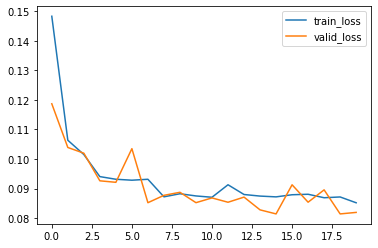

In [17]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train_loss', 'valid_loss'])

In [19]:
state = {
        'model': trainer.model.module if device == 'cuda' else trainer.model,
        }

torch.save(state, 'model.h5')
 

AttributeError: Can't pickle local object '_initialize.<locals>.patch_forward.<locals>.new_fwd'

In [1]:
checkpoint = {'state_dict': model.state_dict()}
torch.save(checkpoint, 'model.h5')

NameError: name 'model' is not defined